<a href="https://colab.research.google.com/github/jhwn533/Pallet-Town/blob/main/petit_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 수집

In [1]:
import pandas as pd
import requests
import time

In [2]:
def get_one_page(page_no):
    '''
    페이지 목록의 상세페이지 주소를 수집해 청원취지까지 수집하는 함수
    '''
    item_list = []
        
    # 목록 수집
    url = f'https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&recordCountPerPage=8&sort=AGRE_END_DE-&searchCondition=sj&searchKeyword=&petitRealmCode=&sttusCode=PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn=RESULT_CODE&beginDate=20220101&endDate=20221231&ageCd='
    response = requests.get(url)
    
    df = pd.read_json(response.text)
    try:
        #상세페이지 수집
        petitIds = df["petitId"]

        for petitId in petitIds:
            detail_url = f'https://petitions.assembly.go.kr/api/petits/{petitId}?petitId={petitId}'
            detail_df = requests.get(detail_url).json()
            item_list.append(detail_df)

        page = pd.DataFrame(item_list)

        edit_page = page[['petitSj','petitObjet', 'petitCn','petitRealmNm','jrsdCmitNm','resultCodeNm','agreCo','agreEndDe']]

        edit_page = edit_page.rename(columns={
            'petitObjet' : '청원취지',
            'petitSj' : '제목', 
            'petitCn' : '내용', 
            'petitRealmNm' : '분야', 
            'jrsdCmitNm' : '담당부서', 
            'resultCodeNm' : '결과', 
            'agreEndDe' : '동의종료일', 
            'agreCo': '동의수'})
        
        return edit_page
    
    except Exception as e:
        return None

def get_pages():
    '''
    페이지 수집 반복 함수
    '''
    page_no = 1
    pages = []

    while True:
        page = get_one_page(page_no)
        if page is None:
            break
        pages.append(page)
        page_no += 1

    time.sleep(1)
    
    df = pd.concat(pages, ignore_index=True)
    
    return df

In [ ]:
all_petit =get_pages()
all_petit

In [4]:
# file_name = 'data/agreeEnded_petits.csv'
# all_petit.to_csv(file_name, index=False)

all_petit = pd.read_csv('agreeEnded_petits.csv')

In [5]:
petit_sort = all_petit.sort_values(['제목', '동의수'], ascending = False)
dp_del = petit_sort.drop_duplicates(subset = ['제목'])
dp_del = dp_del.drop_duplicates(subset = ['청원취지']) # 범주 기술통계 보니 제목이 미세하게 다르지만, 취지가 같은게 4개였음
dp_del

,제목,청원취지,내용,분야,담당부서,결과,동의수,동의종료일
158,흉악범 사형집행을 요청합니다에 관한 청원,사형제도 특별법을 만들어서 사형집행을 해주셨으면 좋겠습니다\r\n사회에서 완전히 격...,"아무리 흉포한 죄를 지었더라도 사형선고는 커녕 무기징역에 그치는 경우가 많으며, 설...",수사/법무/사법제도,법제사법위원회,동의만료폐기,336,2022-08-25 23:59:59
43,환전사기범들 꼭잡아주세요에 관한 청원,보이스 피싱과 유사한 사기임에도 불구하고 아무런 법안이 마련되어 있지 않아서 피해자...,보이스 피싱과 유사하면서도 더 악랄하게 사기꾼들은 피해자의 믿음을 사기 위해 접근한...,소비자/공정거래,정무위원회,동의만료폐기,218,2022-12-01 23:59:59
153,화성연쇄살인 몽타주 도용으로 반 묻지마 제보 법과 반 묻지마 대처 법 제정을 청원합...,화성연쇄살인 이춘재 옆 얼굴 몽타주는 1988년 9월 저의 얼굴 사진을 도용해 만들...,화성연쇄살인 이춘재 옆 얼굴 몽타주는 1988년 9월 10일 만든 것으로 저의 얼굴...,수사/법무/사법제도,법제사법위원회,동의만료폐기,125,2022-08-25 23:59:59
72,형사소송법 제70조 구속의 사유에 피해자 보호를 위한 사유 추가에 관한 청원,현재 스토킹범죄로 인하여 무고한 생명이 죽어가고 있습니다. 구속영장이 도주우려가 없...,현재 신당역 살인 사건을 포함하여 '여친을 2분 간격 10시간 전화해 스토킹...결...,수사/법무/사법제도,법제사법위원회,동의만료폐기,204,2022-11-11 23:59:59
131,해운대 관광컨셉시설 이행 촉구에 관한 청원,해운대 관광컨셉시설은 시민과의 약속입니다,부산 해운대 엘시티 분양 당시 상가 몰에 관광컨셉시설이 들어온다고 했습니다. \r\...,문화/체육/관광/언론,문화체육관광위원회,동의만료폐기,303,2022-09-08 23:59:59
...,...,...,...,...,...,...,...,...
47,10년째 동결된 가정양육수당 인상 요구에 관한 청원,▶ 2013년부터 정부가 전계층 무상보육 정책을 시행하였음. 그런데 2022년 기준...,"▶ 만 2세 아이를 기준으로 어린이집에서 다니는 아이들은 기본보육료 364,000 ...",복지/보훈,보건복지위원회,동의만료폐기,2978,2022-11-30 23:59:59
48,10년공공임대아파트 관련 공공주택특별법 개정법률안 조속 통과에 관한 청원,"공공주택특별법 일부개정법률안(대표발의 의원님: 김상희, 김회재, 김은혜, \r\n박...",【청원의 이유 및 내용】\r\n\r\n1. 5년공공임대주택과 10년공공임대주택이 기...,국토/해양/교통,국토교통위원회,동의만료폐기,140,2022-11-30 23:59:59
45,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,정무위원회,동의만료폐기,28405,2022-11-30 23:59:59
289,"""2020년에 동물학대범 1014명이 검거됐으며 1명이 구속됐다"" 동물보호법을 강화...",동물보호법 개정과 강화,또 “지난 10년간 전국적으로 약 4400명의 동물보호법 위반 사범 중 고작 구속된...,농업/임업/수산업/축산업,농림축산식품해양수산위원회,동의만료폐기,2077,2022-06-10 23:59:59


# 데이터 처리

In [6]:
data_set = dp_del

In [ ]:
# # 그래프 한글 깨짐 해결 (@주피터 노트북)
# from matplotlib import font_manager, rc

# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
# rc('font', family=font_name)

## 1. 분야별 청원 개수

In [7]:
# 분야별 청원 결과
bar_table = pd.crosstab(data_set['분야'],data_set['결과'])
bar_table

결과,동의만료폐기,본회의불부의,위원회심사,위원회접수후철회
분야,,,,
과학기술/정보통신,8,1,0,0
교육,24,0,0,0
국토/해양/교통,40,0,0,0
기타,12,0,0,0
농업/임업/수산업/축산업,13,0,1,0
문화/체육/관광/언론,11,0,1,0
보건의료,49,0,4,0
복지/보훈,10,0,0,0
산업/통상,19,0,3,0


In [ ]:
# 한글폰트 해결(colab)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [8]:
import matplotlib.pyplot as plt

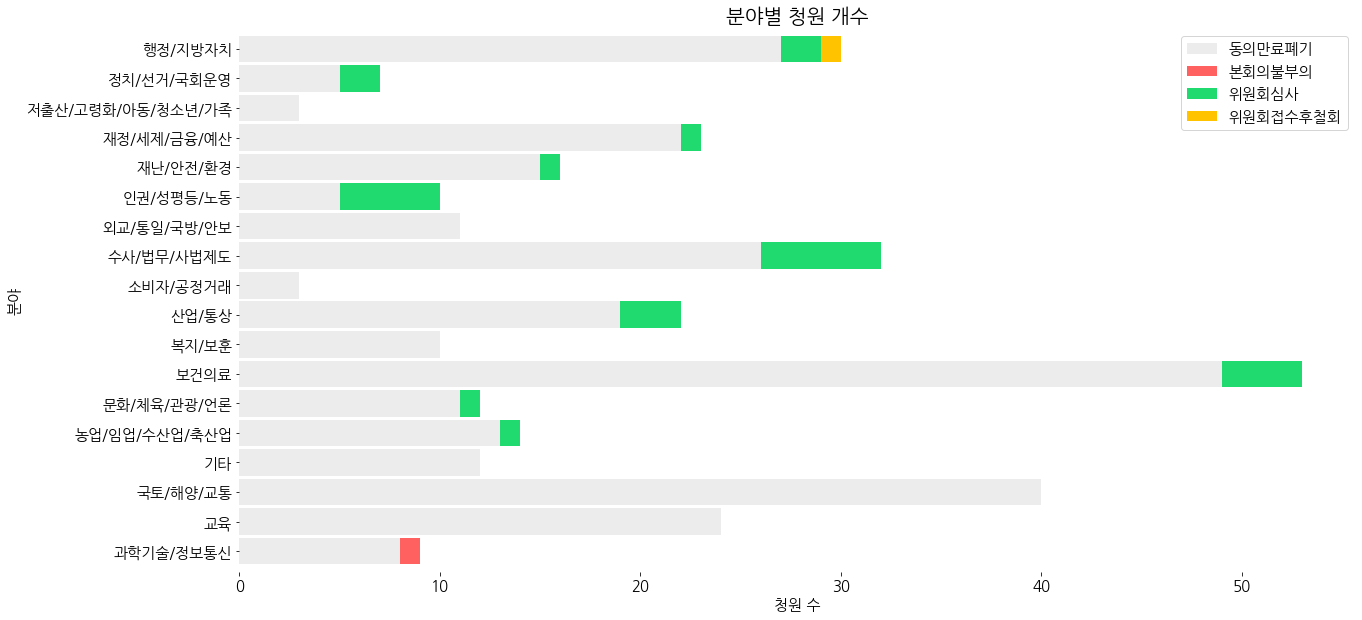

In [18]:
bar_table.plot.barh(rot=0, stacked=True, figsize=(20, 10), width=0.9,
                    color={'동의만료폐기': '#ECECEC', '본회의불부의': '#FF6060', '위원회심사': '#21DA6F', '위원회접수후철회': '#FFC300'}, fontsize=15)
plt.title('분야별 청원 개수', fontsize = 20)
plt.xlabel('청원 수', fontsize=15)
plt.ylabel('분야', fontsize=15)
plt.legend(fontsize=15)
plt.box(False)
plt.rc('font', family='NanumGothic') 
plt.show()

## 성립청원

In [19]:
success = data_set.loc[data_set['동의수'] >= 50000]
success.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 309 to 338
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      28 non-null     object
 1   청원취지    28 non-null     object
 2   내용      28 non-null     object
 3   분야      28 non-null     object
 4   담당부서    28 non-null     object
 5   결과      28 non-null     object
 6   동의수     28 non-null     int64 
 7   동의종료일   28 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.0+ KB


## 미성립청원

In [20]:
fail = data_set.loc[data_set['동의수'] < 50000]
fail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 158 to 58
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      303 non-null    object
 1   청원취지    303 non-null    object
 2   내용      303 non-null    object
 3   분야      303 non-null    object
 4   담당부서    303 non-null    object
 5   결과      303 non-null    object
 6   동의수     303 non-null    int64 
 7   동의종료일   303 non-null    object
dtypes: int64(1), object(7)
memory usage: 21.3+ KB


In [21]:
# 미성립청원 동의수 top10
fail.sort_values('동의수', ascending = False).head(10)

,제목,청원취지,내용,분야,담당부서,결과,동의수,동의종료일
98,"구멍 뚫린 GMO수입검역체계 OUT, 유전자변형생물체의국가간이동등에관한법률의 개정에...",▶전 세계 약 180개 국가는 GMO의 인체 ·환경 피해를 사전방지하기 위해 공동의...,1996년 GMO가 처음 상업화된 후 30년 가까운 시간이 흘렀어도 논쟁이 계속되고...,산업/통상,산업통상자원중소벤처기업위원회,동의만료폐기,35303,2022-10-23 23:59:59
300,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,법제사법위원회,동의만료폐기,34004,2022-05-20 23:59:59
45,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,정무위원회,동의만료폐기,28405,2022-11-30 23:59:59
329,코로나 백신 특검 요청에 관한 청원,"너무나도 많은 국민이 백신 부작용으로 큰 피해를 보고 있고, 정작 최선의 대안은 백...",에코헬스 얼라이언스(EcoHealth Alliance)의 회장 피터 다작(Peter...,수사/법무/사법제도,법제사법위원회,동의만료폐기,27092,2022-01-20 23:59:59
224,촉법소년인 학교폭력 및 성폭행 가해자들의 엄중 처벌에 관한 청원,촉법소년 이란 이유로 너무나도 큰 죄를 지었음에 불구하고 처벌이 되지 않는다는것은 ...,조카가 초등학교 3학년입니다 동급생 친구와\r\n같은학교 6학년 형들에게 꾸준한 학...,수사/법무/사법제도,법제사법위원회,동의만료폐기,26796,2022-07-15 23:59:59
127,부모급여 소급적용에 관한 청원,내년부터 부모급여가 시행될 예정으로 알고있습니다.\r\n만0세부터 70만원인데\r\...,내년부터 부모급여가 시행될 예정으로 알고있습니다.\r\n만0세부터 70만원인데\r\...,복지/보훈,보건복지위원회,동의만료폐기,23494,2022-09-21 23:59:59
18,곰 사육 금지 및 보호에 관한 특별법안 통과에 관한 청원,‘곰 사육 금지 및 보호에 관한 특별법안’ 국회 통과를 통해 부끄러운 곰 사육 산업...,‘웅담채취용 사육곰’ \r\n모든 곰은 국제적 멸종위기종으로 철저히 보호받습니다. ...,재난/안전/환경,환경노동위원회,동의만료폐기,21560,2022-12-22 23:59:59
279,일회용컵 보증제도 폐지에 관한 청원,프렌차이즈 가맹점을 대상으로한 상호 협의없는 강압적이고 불합리한 규제를 폐지하기 위함.,- 프렌차이즈란 ? \r\n가맹본부가 직영점으로 운영하는 매장이아닌 개인사업자가 가...,재난/안전/환경,환경노동위원회,동의만료폐기,17979,2022-06-18 23:59:59
56,2023년 육휴급여와 부모급여 중복지원 강력 요구에 관한 청원,저출산과 복지를 위함에 있어 현실반영없이 퇴행하려는 정책을 막기 위함입니다,10월 뉴스기사 내용을 토대로 문제의 심각성을 느껴 청원하는 바입니다. 2023년부...,보건의료,보건복지위원회,동의만료폐기,17658,2022-11-25 23:59:59
148,외고 폐지를 멈춰주세요에 관한 청원,외고 존치를 위하여,"안녕하세요, 올해 외고 1학년으로 입학해 현재까지 학교에 너무 만족하며 생활하고 있...",교육,교육위원회,동의만료폐기,16719,2022-08-31 23:59:59
